In [47]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from numpy import mean, std, random
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Geospatial
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle


In [43]:
# df is original, df2 is normalized, df3 is the data from 5 testing regions
df = pd.read_csv("6_primaries.csv")
df = df.drop(['country','continent','stateProvince','Unnamed: 0','gbifID','eventDate','species','key','decimalLatitude', 'decimalLongitude'], 
              1)
df2 = pd.read_csv('6_primaries_normalized.csv').drop(['Unnamed: 0', 'decimalLatitude', 'decimalLongitude'],1)

# read in old test data, but use as traning
df3 = pd.read_csv('model_test_data_11vars.csv').drop(['Unnamed: 0.1', 'Unnamed: 0', 'gbifID', 'eventDate', 'country',
                                                            'continent', 'stateProvince', 'decimalLatitude', 'decimalLongitude',
                                                            'aet_mean', 'def_mean', 'pet_mean', 'vpd_mean','q_mean'],1)
df3 = df3[ (df3['species'] == 'Litoria Fallax') | (df3['species'] == 'Crinia Signifera') ]

In [6]:
df2.head()

,occurrenceStatus,normalized_ppt_mean,normalized_srad_mean,normalized_tmax_mean,normalized_tmin_mean,normalized_vap_mean,normalized_ws_mean
0,0,0.013023,0.013477,0.010380,0.008058,0.010088,0.012405
1,0,0.012496,0.013287,0.013917,0.014849,0.014225,0.014817
2,0,0.017151,0.013311,0.013294,0.014386,0.013966,0.013461
3,0,0.011218,0.013485,0.013908,0.013345,0.013509,0.012356
4,0,0.014923,0.013330,0.013624,0.014854,0.014188,0.013989


In [8]:
df3.head()

,species,occurrenceStatus,key,ppt_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,ws_mean
0,Crinia Signifera,0,1,81.216667,198.766667,23.756668,13.061669,1.433333,3.653333
1,Crinia Signifera,0,2,91.050000,199.566667,23.498334,14.031668,1.478333,4.345000
2,Crinia Signifera,0,3,90.416667,196.750000,23.260002,12.676668,1.400167,3.593333
8,Crinia Signifera,0,10,61.850000,201.200000,23.833335,10.403335,1.233833,2.513333
9,Crinia Signifera,0,11,90.416667,196.750000,23.260002,12.676668,1.400167,3.593333


**Possible problem is that we don't have enough training data.** 

**This LR_2 notebook will try to (1) use LR1_testing data (unbalanced) as training, test on self & on LR1_training data(balanced), (2) use LR1_testing and LR1_training both as training ,test on itself, (3)maybe in another new notebook, generate new pseudoabsence data for the unbalanced set.**

## Model1: LR on 6 vars, all normalized, switch training and testing data
**i.e., df2 as testing, df3 as training**

F1 Score: 0.8009808574592628
Accuracy: 0.7190710138454667


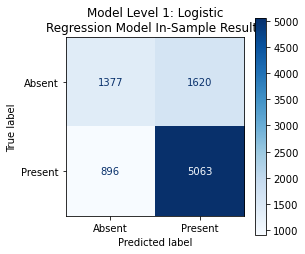

Accuracy: 0.718 (0.014)


In [13]:
# Train model1, but since training data is unbalanced, need to weigh
model1 = LogisticRegression(class_weight = 'balanced')

# Separate the predictor variables from the response
X = df3.drop(['occurrenceStatus','species','key'], 1)
y = df3.occurrenceStatus.astype(int)

# Prepare a test set with new region
X_test = df2.drop(['occurrenceStatus'],1)
y_true= df2['occurrenceStatus']

# Fit model
model1.fit(X, y)

# Use model1 to predict on its own training set and print test results
y_predictself = model1.predict(X)
print(f"F1 Score: {np.mean(f1_score(y, y_predictself))}")
print(f"Accuracy: {np.mean(accuracy_score(y, y_predictself))}")

# Draw confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(model1, X, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((4,4))
disp.ax_.set_title('Model Level 1: Logistic\nRegression Model In-Sample Results')
plt.show()

#a K-fold shuffle test with itself
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(model1, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

**Test model 1 on other area**

F1 Score: 0.0
Accuracy: 0.0


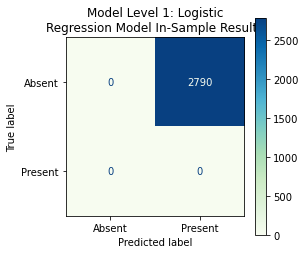

In [27]:
# Use model1 to predict on Greater Sydney Area and print test results
y_predicted = model1.predict(X_test[:2790])
print(f"F1 Score: {np.mean(f1_score(y_true[:2790], y_predicted[:2790]))}")
print(f"Accuracy: {np.mean(accuracy_score(y_true[:2790], y_predicted[:2790]))}")

# Draw confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(model1, X_test[:2790], y_true[:2790], display_labels=['Absent', 'Present'], cmap='GnBu')
disp.figure_.set_size_inches((4,4))
disp.ax_.set_title('Model Level 1: Logistic\nRegression Model In-Sample Results')
plt.show()

## Model2: LR on 6 vars, all normalized, use everything as training data
**i.e., read in df4, the 11var training set, concat with df3(but without dropping the 5 new vars)**

F1 Score: 0.7004092441020703
Accuracy: 0.6575399009356081


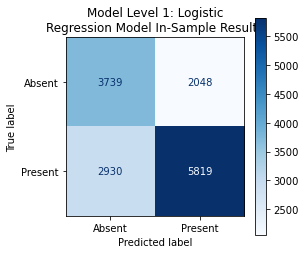

Accuracy: 0.656 (0.010)
              precision    recall  f1-score   support

           0       0.56      0.65      0.60      5787
           1       0.74      0.67      0.70      8749

    accuracy                           0.66     14536
   macro avg       0.65      0.66      0.65     14536
weighted avg       0.67      0.66      0.66     14536



In [50]:
# Train model2, but since training data is unbalanced, need to weigh
model2 = LogisticRegression(class_weight = 'balanced')

# make sure their column names are the same to concat
df2.columns = ['occurrenceStatus', 'ppt_mean', 'srad_mean','tmax_mean', 'tmin_mean', 'vap_mean', 'ws_mean']
X = pd.concat([df3.drop(['occurrenceStatus','species','key'], 1), df2.drop(['occurrenceStatus'],1)])
y = pd.concat([df3.occurrenceStatus.astype(int), df2['occurrenceStatus']])

# Fit model
model2.fit(X, y)

# Use model1 to predict on its own training set and print test results
y_predictself = model2.predict(X)
print(f"F1 Score: {np.mean(f1_score(y, y_predictself))}")
print(f"Accuracy: {np.mean(accuracy_score(y, y_predictself))}")

# Draw confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(model2, X, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((4,4))
disp.ax_.set_title('Model Level 1: Logistic\nRegression Model In-Sample Results')
plt.show()

#a K-fold shuffle test with itself
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model scores = cross_val_score(model2, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
print( metrics.classification_report(y, model2.predict(X)))

## Model3: LR on 11 vars, all normalized, use everything as training data
**i.e., df2 + df3 as training**
### Stopped here w6 Tue bc had no Greater Sydney 11 vars data

In [56]:
df4 = pd.read_csv('model_data_11vars.csv')
df3 = pd.read_csv("6_primaries.csv").drop(['Unnamed: 0', 'gbifID', 'eventDate', 'country', 'continent',
       'stateProvince', 'decimalLatitude', 'decimalLongitude', 'species','key'],1)

In [57]:
df3.columns

Index(['occurrenceStatus', 'ppt_mean', 'srad_mean', 'tmax_mean', 'tmin_mean',
       'vap_mean', 'ws_mean'],
      dtype='object')

In [156]:
# what is the range of the 6 vars? 
df3 = pd.read_csv("6_primaries.csv")
df3 = df3[['occurrenceStatus','ppt_mean','srad_mean','tmax_mean','tmin_mean','vap_mean','ws_mean']]
df3

,occurrenceStatus,ppt_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,ws_mean
0,0,73.350000,197.01666,17.966670,7.081669,0.991667,3.368333
1,0,70.383330,194.25000,24.088335,13.050002,1.398333,4.023333
2,0,96.600000,194.60000,23.010002,12.643335,1.372833,3.655000
3,0,63.183334,197.13333,24.073334,11.728335,1.328000,3.355000
4,0,84.050000,194.86667,23.581669,13.054999,1.394667,3.798333
...,...,...,...,...,...,...,...
5575,1,73.933334,192.83333,23.933336,13.291668,1.412000,4.300000
5576,1,73.933334,192.83333,23.933336,13.291668,1.412000,4.300000
5577,1,85.166664,195.68333,23.146670,12.186667,1.352667,3.651667
5578,1,90.416664,194.50000,23.373333,13.133334,1.400833,3.763333
